In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import random
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from numpy import vstack
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
data_path = '../data/'

In [3]:
data = pd.read_csv(data_path+ 'data_labs_nolastvisit_aettplus1_med1.csv', index_col=0)

In [4]:
data.head()

,People,Visit,Hem,Wbc,Neu,bad_event,Treatment_0,Treatment_1,Treatment_2,Treatment_3,...,AE_t_264,AE_t_265,AE_t_266,AE_t_267,AE_t_268,AE_t_269,AE_t_270,AE_t_271,AE_t_272,AE_t_273
0,0,0,120.0,6.2,1.92,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,128.0,5.8,1.28,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,131.0,4.3,1.12,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,3,115.0,4.0,0.84,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,4,114.0,5.0,3.31,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data.People.nunique()

971

In [6]:
#need to combine rare events to 'AE_other'
rare_events=[]
for i in range(0, 274):
  if(data['AE_t_'+str(i)].sum() < 50):
    rare_events.append('AE_t_'+str(i))

In [7]:
#create a column with rare events
data['AE_t_other'] = 0
for i in rare_events:
  data['AE_t_other']+= data[i]

In [8]:
data['AE_t_other'].sum()

1875

In [9]:
data = data.drop(columns=rare_events)

In [10]:
data = data.rename(columns = { i: "_AE_t_"+i[5:] for i in  data.columns if i.startswith("AE_t") } )

In [11]:
filter_col = [col for col in data if col.startswith('_AE_t_')]

In [12]:
data.loc[(data['_AE_t_other'] != 0), '_AE_t_other'] = 1

In [13]:
data = data.set_index(['People', 'Visit'])

In [14]:
keep_columns = [col for col in data if col.startswith('_AE_t_')]

for i in range(0, 5):
  keep_columns.append('Treatment_'+str(i))

for i in range(0, 101):
  keep_columns.append('Medication_'+str(i))



In [15]:
keep_ae_nums = ['AE_'+col[6:] for col in data if col.startswith('_AE_t_')]

In [16]:
rare_ae = [col for col in data if (col.startswith('AE_') ) & (col not in keep_ae_nums)]

In [17]:
#create a column with rare events
data['AE_other'] = 0
for i in rare_ae:
  data['AE_other']+= data[i]

In [18]:
keep_ae_nums.extend(['AE_other'])

In [19]:
keep_columns.extend(keep_ae_nums)

In [20]:
keep_columns = keep_columns[:-1]

In [21]:
data = data[keep_columns].copy()

In [22]:
data.shape

(7317, 218)

trial data class

In [ ]:
class trial_data(Dataset):
    # load the dataset
    def __init__(self, X, y):
        self.X = X
        self.y = y

        self.X = self.X.astype('float32')
        self.y = self.y.astype('float32')
        #self.y = self.y.reshape((len(self.y), 1))

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X.iloc[idx, :].to_numpy(), self.y.iloc[idx, :].to_numpy()]

In [ ]:
def prepare_data(X_train, y_train, X_val, y_val, X_test, y_test, batch_size =64):
    # load the dataset
    train = trial_data(X_train, y_train)
    val = trial_data(X_val, y_val)
    test = trial_data(X_test, y_test)
    
    batch_size =batch_size
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=batch_size, shuffle=False)#, drop_last=True)
    val_dl = DataLoader(val, batch_size=batch_size, shuffle=False)
    test_dl = DataLoader(test, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl, test_dl

In [ ]:
data = data.reset_index()
random.seed(0)
test_indices = random.sample(data.People.unique().tolist(), 100)
test_data = data[data['People'].isin(test_indices)]
train_data = data[~data['People'].isin(test_indices)]
train_data = train_data.set_index(['People', 'Visit'])
test_data = test_data.set_index(['People', 'Visit'])

In [ ]:
train_data.shape

(6566, 218)

In [ ]:
AE_voc = len(filter_col)

In [ ]:
AE_voc

56

In [ ]:
med_cols = [col for col in data if col.startswith('Medication_')]

In [ ]:
keep_ae_nums = keep_ae_nums[:-1]

In [ ]:
features=med_cols

for i in range(0, 5):
  features.append('Treatment_'+str(i))


labels = keep_ae_nums

In [ ]:
X = train_data[ features]
y = train_data[labels]

In [ ]:
y_ = y.copy()

In [ ]:
#last 5 columns are treatments
X.iloc[0:5, :-5]

Medication_0  Medication_1  Medication_2  Medication_3  \
People Visit                                                           
0      0                 0             1             1             1   
       1                 0             0             1             1   
       2                 0             0             1             1   
       3                 0             0             1             1   
       4                 0             0             0             1   

              Medication_4  Medication_5  Medication_6  Medication_7  \
People Visit                                                           
0      0                 0             0             0             0   
       1                 0             0             0             0   
       2                 0             0             0             0   
       3                 0             0             0             0   
       4                 0             0             0             0   

              Medication_8  Medication_9  ...  Medication_91  Medication_92  \
People Visit                              ...                                 
0      0                 0             0  ...              0              0   
       1                 0             0  ...              0              0   
       2                 0             0  ...              0              0   
       3                 0             0  ...              0              0   
       4                 0             0  ...              0              0   

              Medication_93  Medication_94  Medication_95  Medication_96  \
People Visit                                                               
0      0                  0              0              0              0   
       1                  0              0              0              0   
       2                  0              0              0              0   
       3                  0              0              0              0   
       4                  0              0              0              0   

              Medication_97  Medication_98  Medication_99  Medication_100  
People Visit                                                               
0      0                  0              0              0               0  
       1                  0              0              0               0  
       2                  0              0              0               0  
       3                  0              0              0               0  
       4                  0              0              0               0  

[5 rows x 101 columns]

In [ ]:
X.shape

(6566, 106)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, train_size=0.9, random_state=0)

In [ ]:
X_test = test_data[features]
y_test = test_data[labels]

In [ ]:
x_train.shape

(5909, 106)

In [ ]:
# Model Hyperparameters

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



batch_size = int(X.shape[0]/2) #1000 #int(6566/2) #6566

x_dim  = 101
hidden_dim = 50
latent_dim = 32

lr = 1e-3

epochs = 1000

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        torch.nn.init.xavier_uniform_(self.FC_input.weight)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        torch.nn.init.xavier_uniform_(self.FC_mean.weight)
        torch.nn.init.xavier_uniform_(self.FC_var.weight)
        
        self.LeakyReLU = nn.ReLU()
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     
                                                       
        
        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        torch.nn.init.xavier_uniform_(self.FC_hidden.weight)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        torch.nn.init.xavier_uniform_(self.FC_output.weight)
        
        self.LeakyReLU = nn.ReLU()
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [ ]:
class AE_module(nn.Module):
  def __init__(self, latent_dim, treatment_dim, hidden_dim, ae_dim):
     super(AE_module, self).__init__()
     self.FC_hidden = nn.Linear(latent_dim+treatment_dim, latent_dim+10)
     self.FC_hidden2 = nn.Linear(latent_dim +10, hidden_dim)
     self.FC_hidden3 = nn.Linear(hidden_dim, hidden_dim)
     self.FC_output = nn.Linear(hidden_dim, ae_dim)
     self.FC_output1 = nn.Linear(ae_dim, ae_dim)
     self.LeakyReLU= nn.ReLU()
     self.bn1 = nn.BatchNorm1d(hidden_dim)
    
  def forward(self, x):
      h     = self.LeakyReLU(self.FC_hidden(x))
      h     = self.bn1(self.LeakyReLU(self.FC_hidden2(h)))
      h     = self.LeakyReLU(self.FC_hidden3(h))
      h     = self.LeakyReLU(self.FC_output(h))
      Med = torch.sigmoid(self.FC_output1(h))
      return Med

In [ ]:
import torch.nn.functional as F

In [ ]:
class DotProductAttention(nn.Module):
    """
    Compute the dot products of the query with all values and apply a softmax function to obtain the weights on the values
    """
    def __init__(self):
        super(DotProductAttention, self).__init__()

    def forward(self, query, value):
        batch_size, input_size = query.size(0),  value.size(1)
        
        score = torch.bmm(query.unsqueeze(1), value.transpose(1, 2))
        attn = F.softmax(score, 2)  
     
        context = torch.bmm(attn, value)

        #print(context.shape)
        return context, attn

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder, AE_module, DotProductAttention):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        self.AE = AE_module
        self.Att = DotProductAttention
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x_ ):
        x = x_[:,:, :-5]
        
        query = x[:, 0, :]
        keys = x[:, 1:, :]

        context, attn = self.Att(query, keys)

        mean, log_var = self.Encoder(context[:,0, :])
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)

        #print(z.shape, x_[:,:, -5:].shape)
        z_1= torch.cat((z, x_[:,0, -5:]), 1)

        AE_out = self.AE(z_1)

        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var , AE_out

In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
ae_module = AE_module(latent_dim=latent_dim, treatment_dim=5, hidden_dim=hidden_dim, ae_dim=AE_voc)
attn_module = DotProductAttention()
model = Model(Encoder=encoder, Decoder=decoder, AE_module=ae_module, DotProductAttention= attn_module).to(DEVICE)

In [ ]:
from torch.optim import Adam

def loss_function(x, x_hat, mean, log_var, AE_out, AE_true):
    #loss = nn.BCEWithLogitsLoss (pos_weight = torch.tensor (5.0), reduction='sum')
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    ae_loss = nn.functional.binary_cross_entropy(AE_out, AE_true, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    #print('Repro loss: ', reproduction_loss, 'KL : ', KLD, 'AE_loss: ', ae_loss)
    return (reproduction_loss + KLD) + 20*ae_loss


optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
train_dl, val_dl, test_dl = prepare_data(X, y, x_val, y_val, X_test, y_test, batch_size=batch_size)

don't run if not training

In [ ]:
print("...Start training VAE...")

best_auc=0
best_train_auc = 0
for epoch in range(epochs):

    model.train()
    print("training epoch:  ", epoch)
    overall_loss = 0
    

    for batch_idx, (x, y) in enumerate(train_dl):
        
        x = x.to(DEVICE)

        optimizer.zero_grad()

        n_cross_n = torch.matmul(x, x.T)

        top_5_index = torch.topk(n_cross_n, 4)

        ext_x=[]
        for i in range(x.shape[0]):
          x_=[]
          x_.append(x[i].tolist())
          x_.extend(x[top_5_index.indices[i]].tolist())
          ext_x.append(x_)

        ext_x= torch.as_tensor(ext_x)
        #print(ext_x[:,:, :-5])

        

        x_hat, mean, log_var, AE_out= model(ext_x)
        


        loss = loss_function(x[:, :-5], x_hat, mean, log_var, AE_out, y)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    model.train(False)
    if epoch in range(0, epochs, 2): 
      
      #print(" ---- validation ---- ")
      
      model.eval()
      predictions, actuals , proba, x_hats, ins= list(), list(), list(), list(), list()
      for i, (x, y) in enumerate(train_dl):
          # evaluate the model on the test set
          n_cross_n = torch.matmul(x, x.T)

          top_5_index = torch.topk(n_cross_n, 4)

          ext_x=[]
          for j in range(x.shape[0]):
            x_=[]
            x_.append(x[j].tolist())
            x_.extend(x[top_5_index.indices[j]].tolist())
            ext_x.append(x_)

          ext_x= torch.as_tensor(ext_x)
          
          x_hat, mean, log_var, yhat= model(ext_x)

          inp = x.detach().numpy()
          x_hat = x_hat.detach().numpy()
          yhat = yhat.detach().numpy()

          actual = y.numpy()

          proba.append(yhat)
          yhat = yhat.round()
          x_hat = x_hat.round()
          x_hats.append(x_hat)
          predictions.append(yhat)
          actuals.append(actual)
          ins.append(inp)

      predictions, actuals, proba , x_hats, ins= vstack(predictions), vstack(actuals), vstack(proba), vstack(x_hats), vstack(ins)

      # calculate accuracy elementwise
      accs=[]
      recalls=[]
      precisions=[]
      aucs=[]

      #voc length 278
      count = 0
      for j in range(0, AE_voc):
        if len(np.unique(actuals[:, j])) == 2:
          count+=1
          accs.append(accuracy_score(actuals[:, j], predictions[:, j]))
          aucs.append(roc_auc_score(actuals[:, j], proba[:, j]))
          cm = confusion_matrix(actuals[:, j], predictions[:, j], labels=[0, 1])
          

      #avg acc
      avg_acc= np.sum(accs)/count
      #print(avg_acc, "Accuracy")

      avg_auc = np.sum(aucs)/count
      #print(avg_auc, "Avg AUC")

      if best_train_auc< avg_auc:
        best_train_auc = avg_auc
        print('train AUC', best_train_auc)
        torch.save(model.state_dict(), data_path+'best-train_beta20_1000e_m1.pt')
  
        

    if epoch in range(0, epochs, 5): 
      
      #print(" ---- validation ---- ")
      
      model.eval()
      predictions, actuals , proba, x_hats, ins= list(), list(), list(), list(), list()
      for i, (x, y) in enumerate(test_dl):
          # evaluate the model on the test set
          n_cross_n = torch.matmul(x, x.T)

          top_5_index = torch.topk(n_cross_n, 4)

          ext_x=[]
          for j in range(x.shape[0]):
            x_=[]
            x_.append(x[j].tolist())
            x_.extend(x[top_5_index.indices[j]].tolist())
            ext_x.append(x_)

          ext_x= torch.as_tensor(ext_x)
          
          x_hat, mean, log_var, yhat= model(ext_x)

          inp = x.detach().numpy()
          x_hat = x_hat.detach().numpy()
          yhat = yhat.detach().numpy()

          actual = y.numpy()

          proba.append(yhat)
          yhat = yhat.round()
          x_hat = x_hat.round()
          x_hats.append(x_hat)
          predictions.append(yhat)
          actuals.append(actual)
          ins.append(inp)

      predictions, actuals, proba , x_hats, ins= vstack(predictions), vstack(actuals), vstack(proba), vstack(x_hats), vstack(ins)

      # calculate accuracy elementwise
      accs=[]
      recalls=[]
      precisions=[]
      aucs=[]

      #voc length 278
      count = 0
      for j in range(0, AE_voc):
        if len(np.unique(actuals[:, j])) == 2:
          count+=1
          accs.append(accuracy_score(actuals[:, j], predictions[:, j]))
          aucs.append(roc_auc_score(actuals[:, j], proba[:, j]))
          cm = confusion_matrix(actuals[:, j], predictions[:, j], labels=[0, 1])
          

      #avg acc
      avg_acc= np.sum(accs)/count
      #print(avg_acc, "Accuracy")

      avg_auc = np.sum(aucs)/count
      #print(avg_auc, "Avg AUC")

      if best_auc< avg_auc:
        best_auc = avg_auc
        print('AUC', best_auc)
        torch.save(model.state_dict(), data_path+'best_beta20_1000e_m1.pt')


    #print("Overall loss : ", overall_loss, "Batch_idx : ", batch_idx, "Batch_size : ", batch_size)    
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

...Start training VAE...
training epoch:   0
train AUC 0.5020316302925736
AUC 0.49588513607852097
	Epoch 1 complete! 	Average Loss:  902.338671875
training epoch:   1
	Epoch 2 complete! 	Average Loss:  844.8881875
training epoch:   2
train AUC 0.5047348715359758
	Epoch 3 complete! 	Average Loss:  758.057234375
training epoch:   3
	Epoch 4 complete! 	Average Loss:  629.6766197916667
training epoch:   4
	Epoch 5 complete! 	Average Loss:  477.77705208333333
training epoch:   5
AUC 0.5026560335409294
	Epoch 6 complete! 	Average Loss:  359.9600390625
training epoch:   6
	Epoch 7 complete! 	Average Loss:  305.32190104166665
training epoch:   7
	Epoch 8 complete! 	Average Loss:  281.75028385416664
training epoch:   8
train AUC 0.5122228274003029
	Epoch 9 complete! 	Average Loss:  269.74806510416664
training epoch:   9
	Epoch 10 complete! 	Average Loss:  260.6538671875
training epoch:   10
train AUC 0.5218355247731526
AUC 0.513120769282739
	Epoch 11 complete! 	Average Loss:  254.66842447916667

In [ ]:
model.load_state_dict(torch.load(data_path+'best-train_model-parameters_m1.pt'))

<All keys matched successfully>

In [ ]:
#model.load_state_dict(torch.load(data_path+'best-train_beta20_1000e_m1.pt'))

<All keys matched successfully>

In [ ]:

# evaluate the model
def evaluate_model(test_dl, model):
    model.eval()
    predictions, actuals , proba, x_hats, ins= list(), list(), list(), list(), list()
    for i, (x, y) in enumerate(test_dl):
        # evaluate the model on the test set
        n_cross_n = torch.matmul(x, x.T)

        #print(x.shape)
        top_5_index = torch.topk(n_cross_n, 4)

        ext_x=[]
        for j in range(x.shape[0]):
          x_=[]
          x_.append(x[j].tolist())
          x_.extend(x[top_5_index.indices[j]].tolist())
          ext_x.append(x_)

        ext_x= torch.as_tensor(ext_x)
        

        

        x_hat, mean, log_var, yhat= model(ext_x)

        inp = x.detach().numpy()
        x_hat = x_hat.detach().numpy()
        yhat = yhat.detach().numpy()

        actual = y.numpy()

        proba.append(yhat)
        yhat = yhat.round()
        x_hat = x_hat.round()
        x_hats.append(x_hat)
        predictions.append(yhat)
        actuals.append(actual)
        ins.append(inp)

    predictions, actuals, proba , x_hats, ins= vstack(predictions), vstack(actuals), vstack(proba), vstack(x_hats), vstack(ins)

    # calculate accuracy elementwise
    accs=[]
    recalls=[]
    precisions=[]
    aucs=[]

    #voc length 278
    count = 0
    for j in range(0, AE_voc):
      if len(np.unique(actuals[:, j])) == 2:
        count+=1
        accs.append(accuracy_score(actuals[:, j], predictions[:, j]))
        #recalls.append(recall_score(actuals[:, j], predictions[:, j]))
        #precisions.append(precision_score(actuals[:, j], predictions[:, j]))
        aucs.append(roc_auc_score(actuals[:, j], proba[:, j]))
        cm = confusion_matrix(actuals[:, j], predictions[:, j], labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
        disp.plot()
        plt.show()
    #avg acc
    avg_acc= np.sum(accs)/count
    print(avg_acc, "Accuracy")

    avg_auc = np.sum(aucs)/count
    print(avg_auc, "Avg AUC")


    return accs, aucs, predictions, actuals , x_hats ,ins

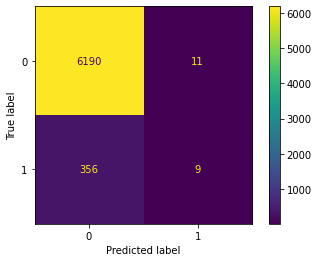

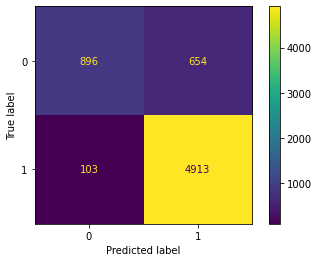

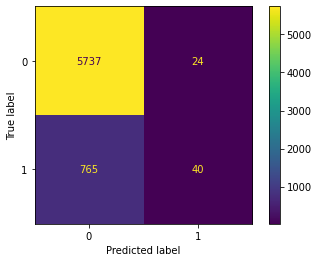

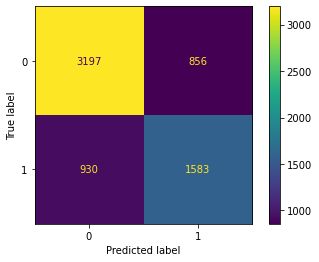

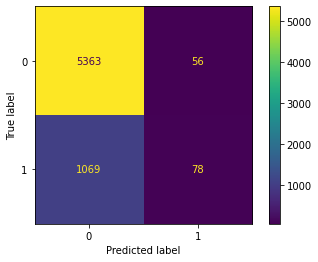

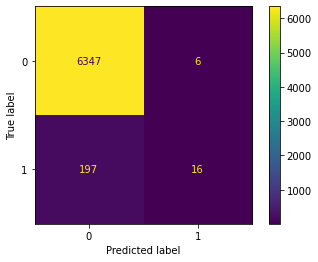

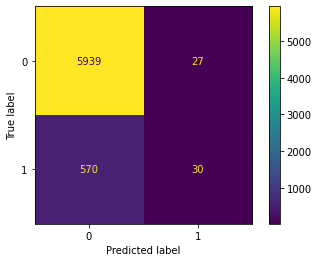

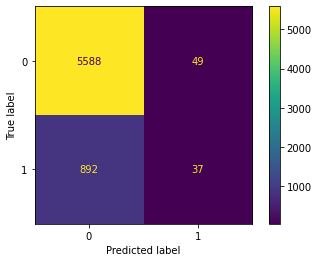

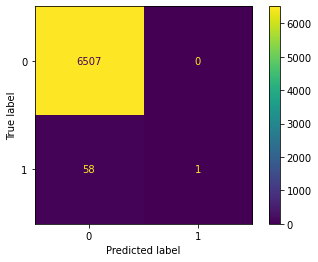

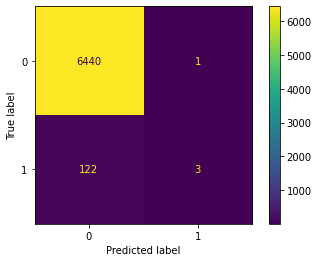

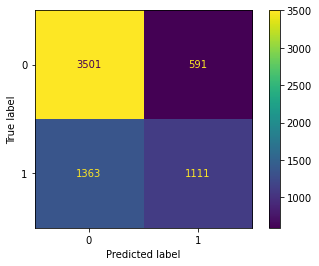

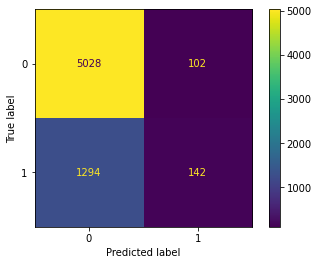

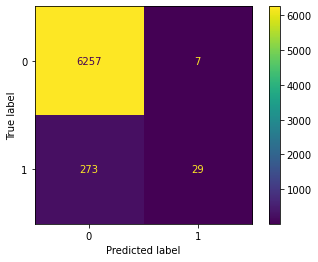

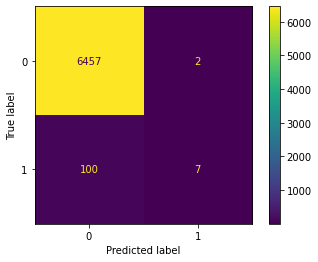

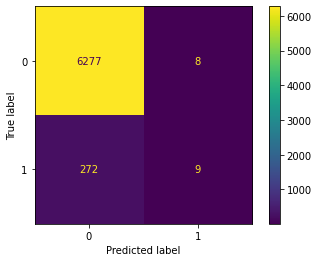

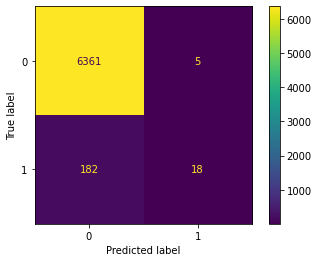

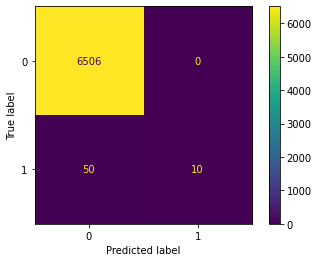

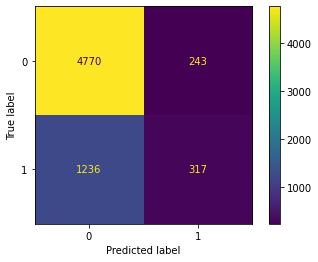

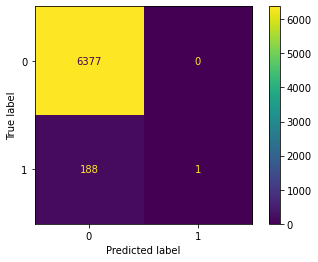

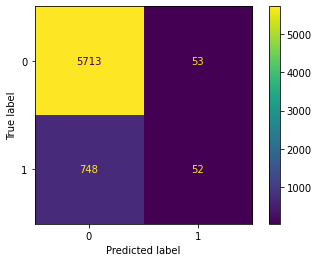

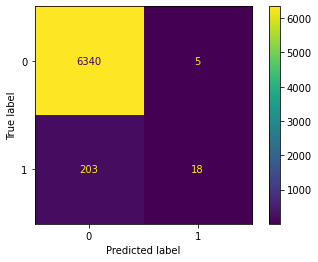

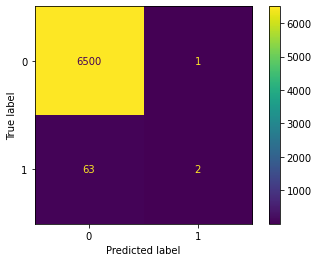

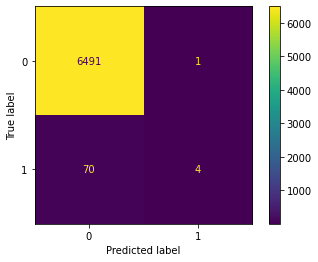

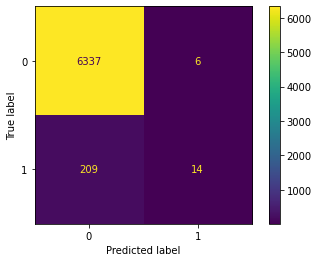

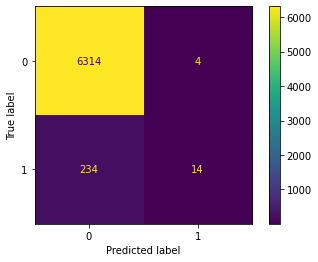

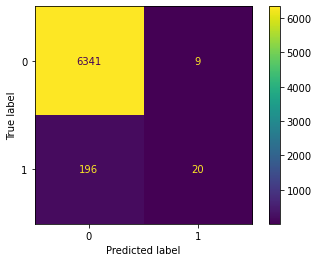

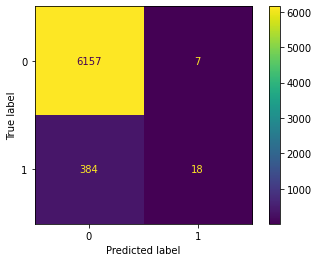

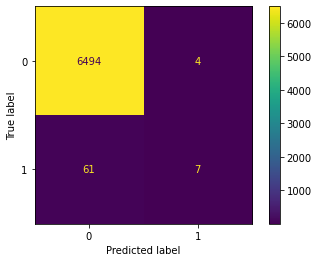

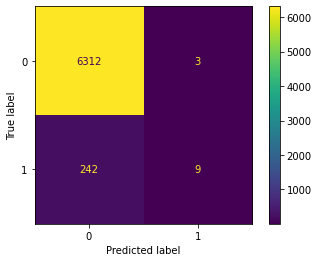

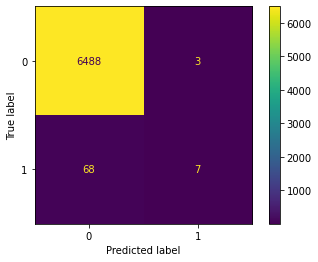

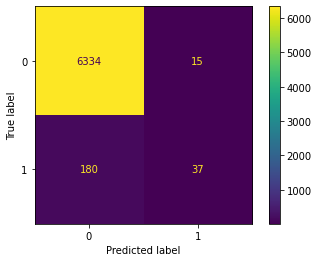

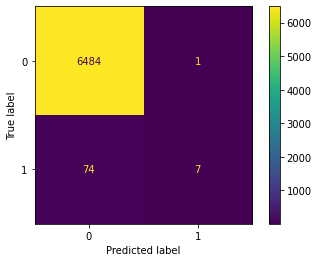

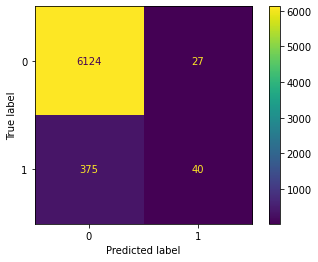

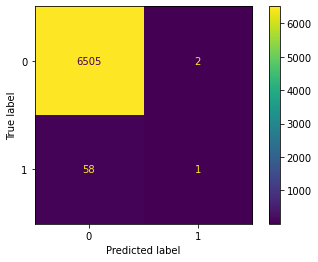

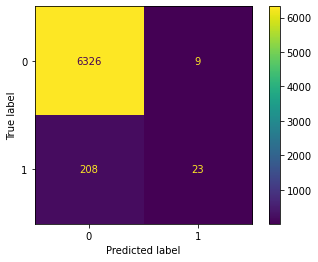

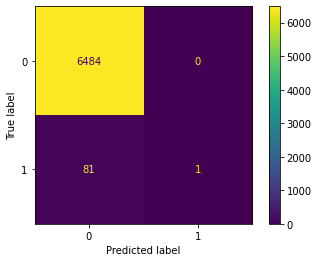

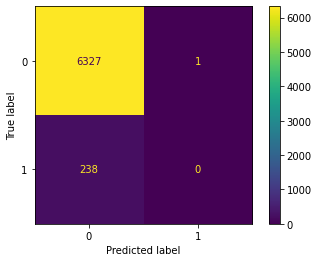

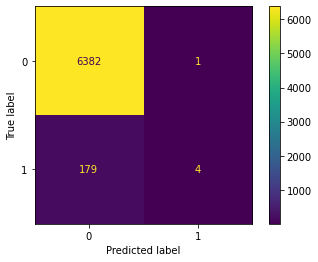

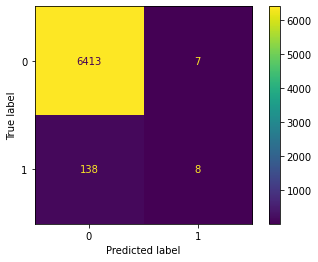

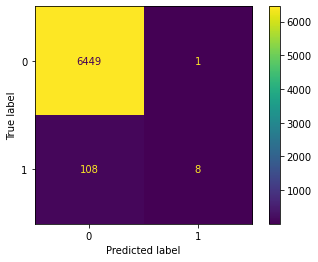

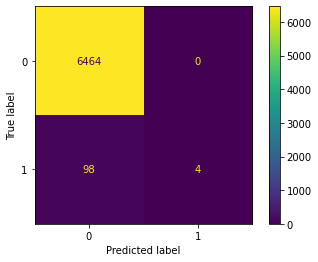

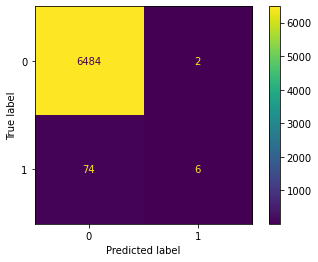

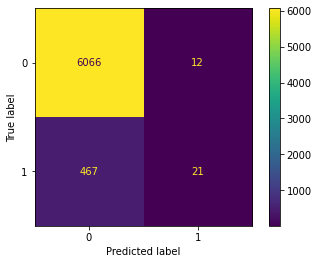

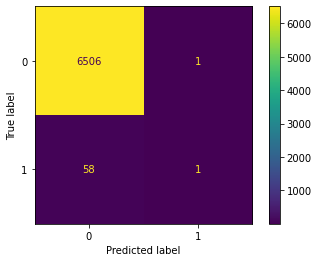

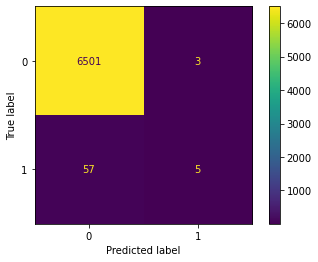

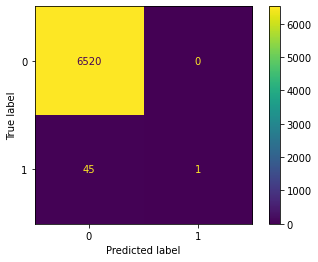

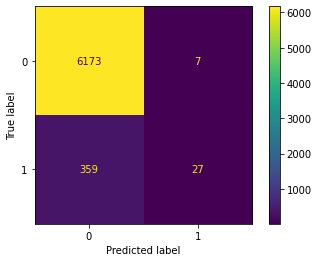

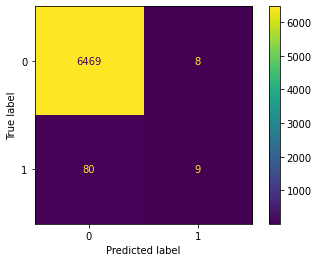

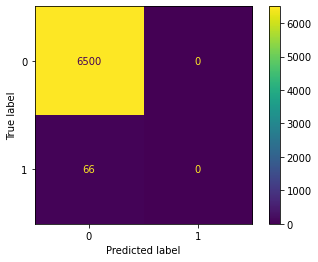

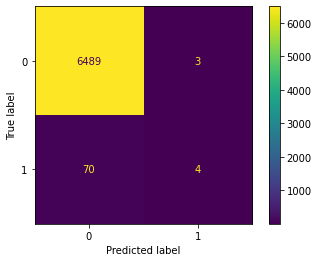

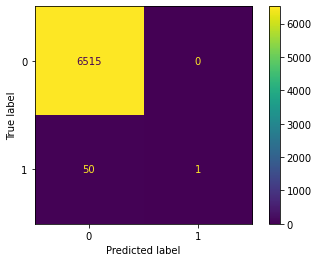

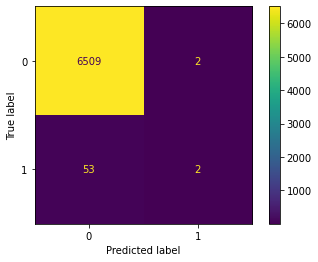

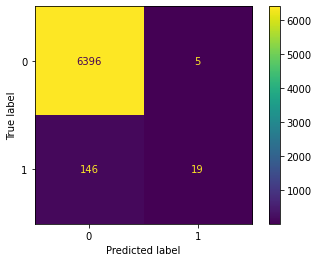

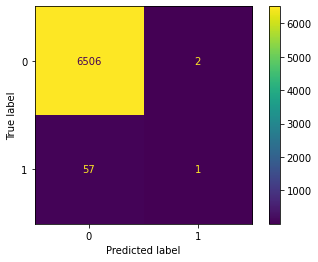

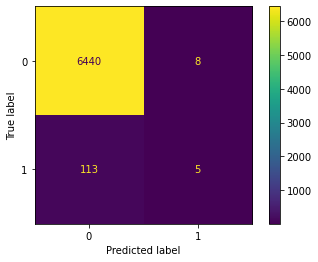

0.9479827209038295 Accuracy
0.8229337561184358 Avg AUC


In [ ]:
accs, aucs,  preds, actual, x_hats, ins= evaluate_model(train_dl, model)

In [ ]:
x_hats[7]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
ins[7]

array([0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0.], dtype=float32)

In [ ]:
print(x_train.iloc[7,:].to_list())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


generate data

In [ ]:
X.shape

(6566, 106)

In [ ]:
x_hats

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
x_hats.shape

(6566, 101)

In [ ]:
#creating new data from training data
augmented=[]
i=0
for index, row in X.iterrows():
  new_row = x_hats[i]
  i=i+1
  augmented.append(new_row)



new_df = pd.DataFrame(data=augmented, index=X.index, columns= X.columns[:-5])

In [ ]:
new_df = new_df.astype('int64')

In [ ]:
new_df = pd.merge(X.loc[:,['Treatment_0', 'Treatment_1', 'Treatment_2', 'Treatment_3', 'Treatment_4']], new_df, how='inner', left_index=True, right_index=True)

In [ ]:
#y = train_data.iloc[:, -AE_voc:]

In [ ]:
new_df = pd.merge(new_df, y_, how = 'inner' , left_index= True, right_index=True)

In [ ]:
new_df.shape

(6566, 162)